In [1]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns
import scipy.odr as odr
from scipy.optimize import curve_fit

%matplotlib notebook

### Load data

In [2]:
df = pd.read_csv('res1_df.csv')
# df

In [3]:
x_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy())
y_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy())

In [4]:
x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_wt_full
y_wt = df[df.Line == 'nwg201'].Mem_post.to_numpy() / y_wt_full

x_pol = df[df.Line == 'nwg325'].Cyt.to_numpy() / x_wt_full
y_pol = df[df.Line == 'nwg325'].Mem_post.to_numpy() / y_wt_full

x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_wt_full
y_l109r = df[df.Line == 'nwg369'].Mem_post.to_numpy() / y_wt_full

# x_ph = df[df.Line == 'od58'].Cyt.to_numpy() / x_wt_full
# y_ph = df[df.Line == 'od58'].Mem_tot.to_numpy() / y_wt_full

### Analysis functions

In [37]:
def fitting(model, cyts, mems, verb=False):
    # Ols fit
    popt, pcov = curve_fit(model, cyts, mems)
    params_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: model(x, *B))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=params_0)
        output = myodr.run()
        return output

    regression = perform_odr(cyts, mems)
    params = regression.beta
    
#     if verb:
#         print((regression.sum_square) ** 0.5)
#         print((cyts + regression.delta) ** 0.5) ## model x
#         print((regression.y) ** 0.5) ## model y
#         ## can then calculate pairwise euclidian distance between model and data
        
#         fig, ax = plt.subplots()
#         for i in range(len(cyts)):
#             xs = [cyts[i], cyts[i] + regression.delta[i]]
#             ys = [mems[i], regression.y[i]]
#             ax.scatter(xs, ys)
#             ax.set_xlim(0, 2)
#             ax.set_ylim(0, 2)
#         fig.set_size_inches(4,4)
        
    return params

def bootstrap_fitting(model, cyts, mems, n):
    params = []
    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        try:
            params.append(fitting(model, cyts[inds], mems[inds]))
        except:
            pass
    
#     fig, ax = plt.subplots()
#     params_array = np.array(params).T
#     ax.scatter(params_array[0], params_array[1], s=1)
#     ax.set_xlim(0, 5)
#     ax.set_ylim(0, 3)
        
    return params

def confidence_interval(model, cyts, mems, n_bootstrap=1000, n_x=100, interval=95):
    params = bootstrap_fitting(model, cyts, mems, n=n_bootstrap)
    
    x = np.linspace(0, max(cyts), n_x)
    all_fits = np.zeros([len(x), len(params)])
    for i, _x in enumerate(x):
        for j, p in enumerate(params):
            all_fits[i, j] = model(_x, *p)
    
    all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=1)
    all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=1)
    params_lower = np.percentile(np.array(params), (100 - interval) / 2, axis=0)
    params_upper = np.percentile(np.array(params), 50 + (interval / 2), axis=0)

    return [x, all_fits_lower, all_fits_upper], [params_lower, params_upper]

def plot_analysis(x, y, model, p, ci, ax, c=None):
    ax.scatter(x, y, c=c)
    ax.plot(np.linspace(0, max(x), 100), model(np.linspace(0, max(x), 100), *p), c=c)
    ax.fill_between(*ci, color=c, alpha=0.1)
    
def full_analysis(model):
    p_wt = fitting(model, x_wt, y_wt, verb=True)
    ci_wt, prange_wt = confidence_interval(model, x_wt, y_wt)

    p_pol = fitting(model, x_pol, y_pol, verb=True)
    ci_pol, prange_pol = confidence_interval(model, x_pol, y_pol)

    p_l109r = fitting(model, x_l109r, y_l109r, verb=True)
    ci_l109r, prange_l109r = confidence_interval(model, x_l109r, y_l109r)

#     p_ph = fitting(model, x_ph, y_ph, verb=True)
#     ci_ph, prange_ph = confidence_interval(model, x_ph, y_ph)
    
    fig, ax = plt.subplots()
    plot_analysis(x_wt, y_wt, model, p_wt, ci_wt, ax, c='tab:blue')
    plot_analysis(x_pol, y_pol, model, p_pol, ci_pol, ax, c='tab:red')
    plot_analysis(x_l109r, y_l109r, model, p_l109r, ci_l109r, ax, c='tab:orange')
#     plot_analysis(x_ph, y_ph, model, p_ph, ci_ph, ax, c='tab:green')
#     ax.set_xlim(left=0)
#     ax.set_ylim(bottom=0)
    ax.set_xlabel('Cytoplasmic concentration')
    ax.set_ylabel('Membrane concentration')
    fig.set_size_inches(4, 4)
    fig.tight_layout()    
    
    fig, ax = plt.subplots()
    yerr = np.abs(np.array([prange_wt - p_wt, prange_pol - p_pol, 
                            prange_l109r - p_l109r])[:, :, 1].T) 
    ax.bar([1, 2, 3], [p_wt[1], p_pol[1], p_l109r[1]], 
           color=['tab:blue', 'tab:orange', 'tab:green'], alpha=0.3, 
           yerr=yerr, capsize=10)
    ax.set_ylabel('Exponent')
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['WT uniform', 'WT polarised', 'L109R uniform'], rotation=45, ha='right')
    fig.set_size_inches(4, 4)
    fig.tight_layout()  

#     fig, ax = plt.subplots()
#     yerr = np.abs(np.array([prange_wt - p_wt, 
#                             prange_l109r - p_l109r, prange_ph - p_ph])[:, :, 1].T) 
#     ax.bar([1, 2, 3], [p_wt[1], p_l109r[1], p_ph[1]], 
#            color=['tab:blue', 'tab:orange', 'tab:green'], alpha=0.3, 
#            yerr=yerr, capsize=10)
#     ax.set_ylabel('Exponent')
#     ax.set_xticks([1, 2, 3])
#     ax.set_xticklabels(['WT', 'L109R', 'PH'], rotation=45, ha='right')
#     ax.set_ylim(bottom=0)
#     fig.set_size_inches(4, 4)
#     fig.tight_layout()  

#     fig, ax = plt.subplots()
#     yerr = np.abs(np.array([prange_wt - p_wt, prange_pol - p_pol])[:, :, 1].T) 
#     ax.bar([1, 2], [p_wt[1], p_pol[1]], 
#            color=['tab:blue', 'tab:red',], alpha=0.3, 
#            yerr=yerr, capsize=10)
#     ax.set_ylabel('Exponent')
#     ax.set_xticks([1, 2])
#     ax.set_xticklabels(['Uniform', 'Polarised'], rotation=45, ha='right')
#     ax.set_ylim(bottom=0)
#     fig.set_size_inches(4, 4)
#     fig.tight_layout()  
    
#     return fig, ax

### Linear fit

In [38]:
def model_linear(x, a):
    return a * x

In [39]:
# full_analysis(model_linear)

### Linear fit free intercept

In [40]:
def model_linear_free(x, a, b):
    return a * x + b

<IPython.core.display.Javascript object>


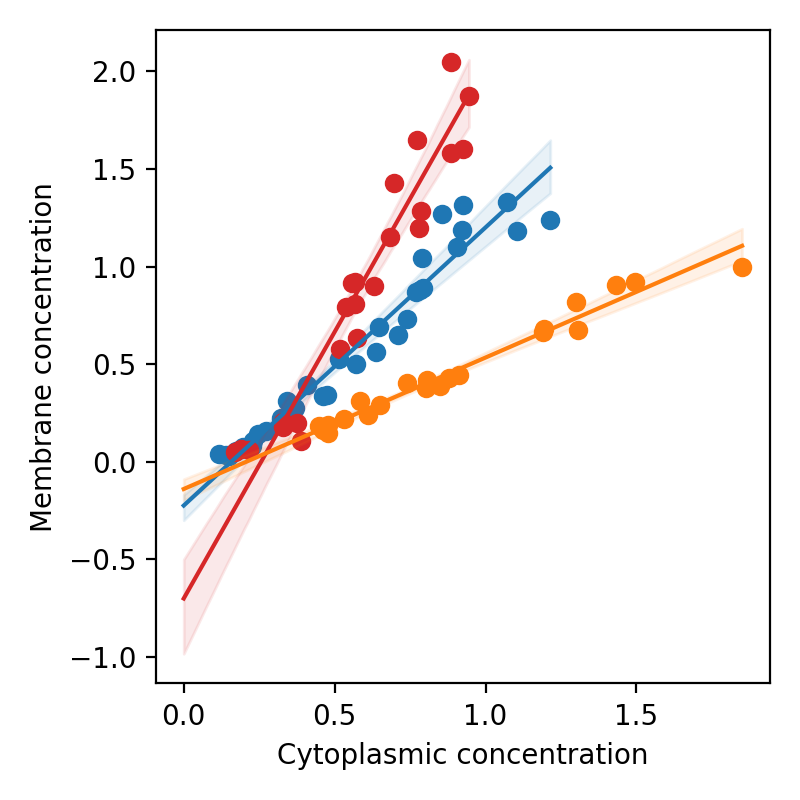

<IPython.core.display.Javascript object>


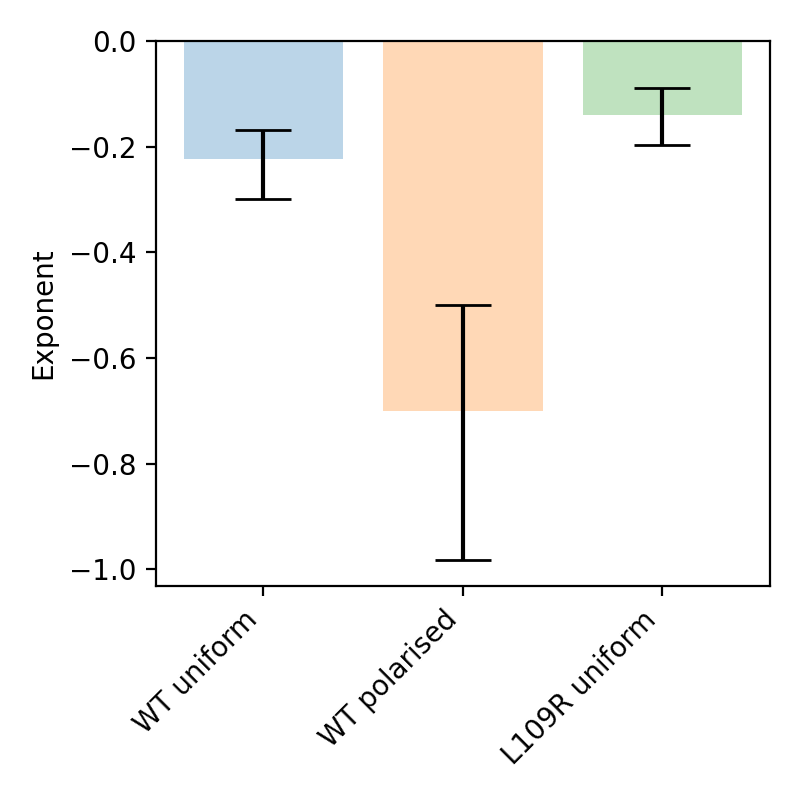

In [41]:
full_analysis(model_linear_free)

### Nonlinear fit

In [42]:
def model_nonlinear(x, a, e):
    return a * (x ** e)

<IPython.core.display.Javascript object>


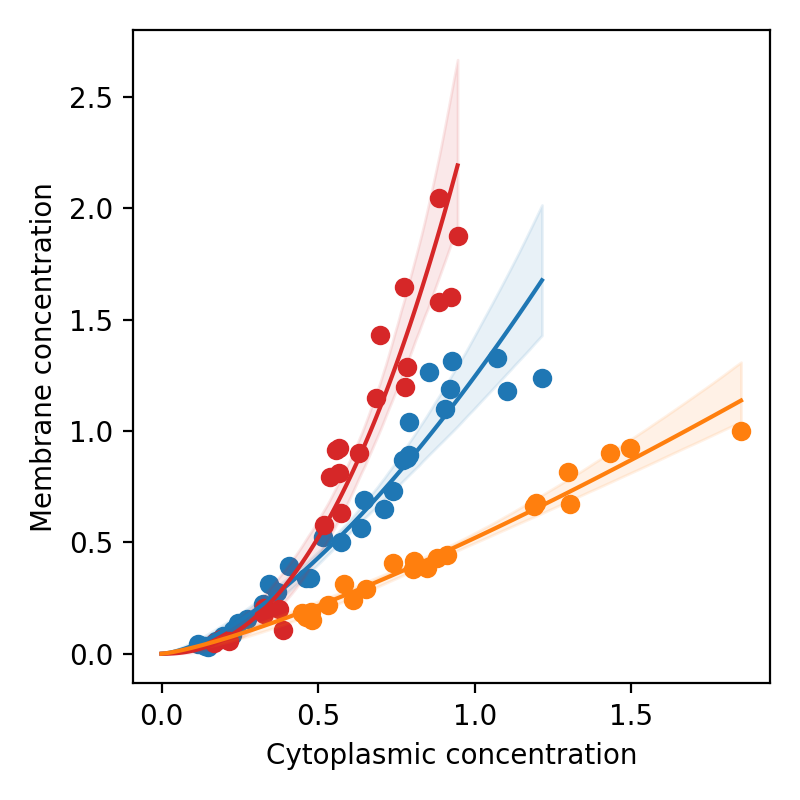

<IPython.core.display.Javascript object>


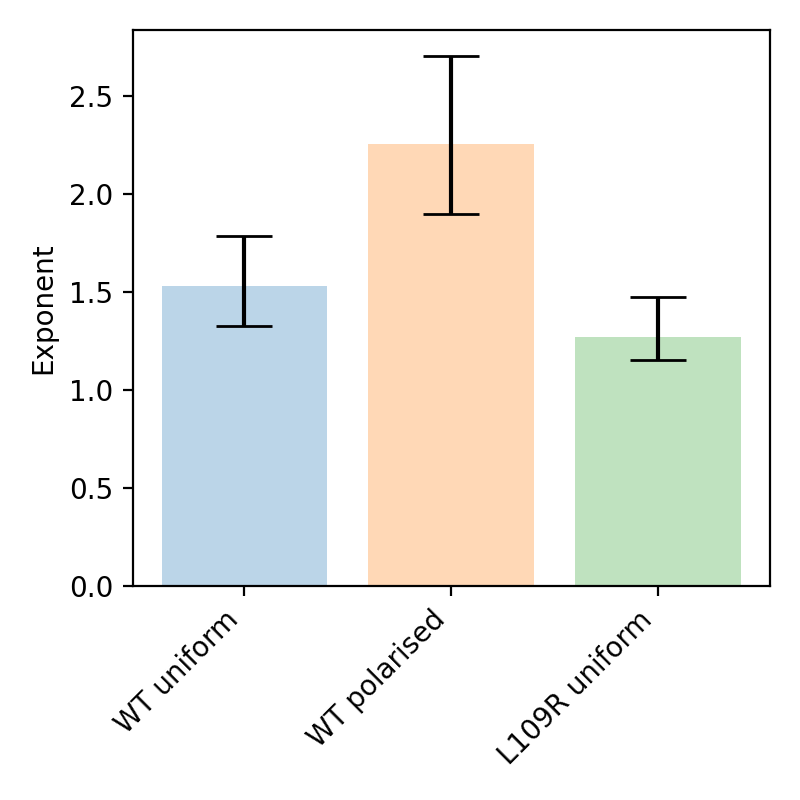

In [43]:
full_analysis(model_nonlinear)

### Nonlinear fit free intercept

In [37]:
# def model_nonlinear_free(x, a, e, i):
#     return a * (x ** e) + i

/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


<IPython.core.display.Javascript object>


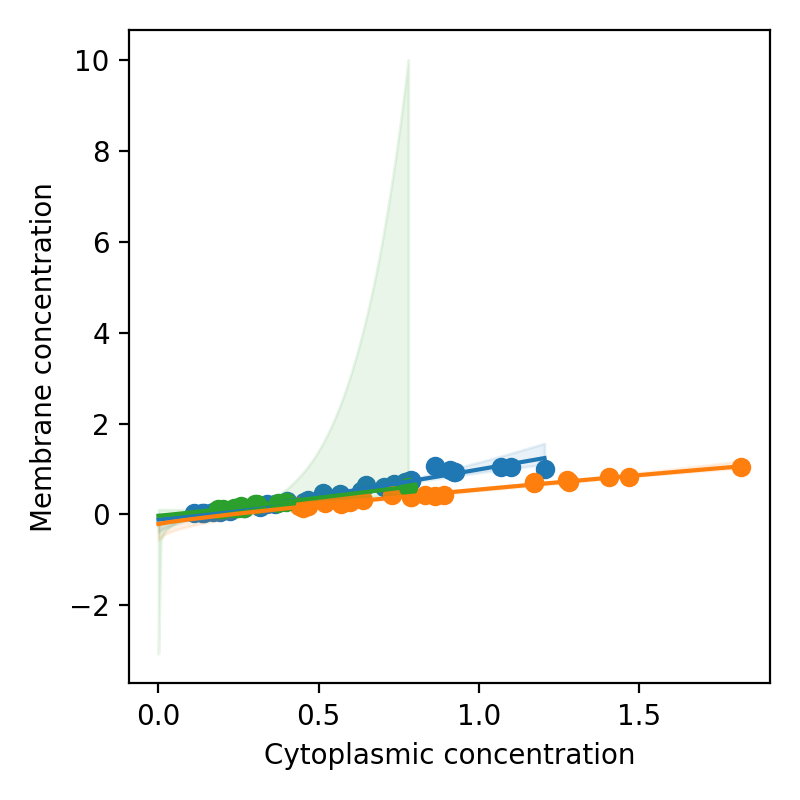

<IPython.core.display.Javascript object>


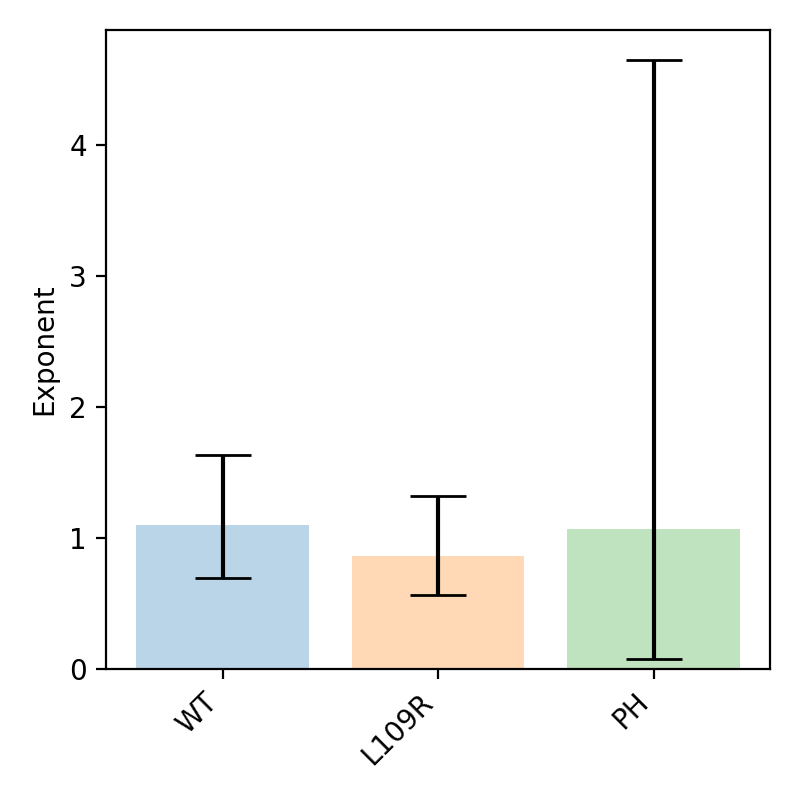

In [38]:
# full_analysis(model_nonlinear_free)